In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import date
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('bank.csv', sep=';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
len(df)

4521

# nowe zmienne/atrybuty

In [5]:
print(df.balance.mean(), df.balance.min(), df.balance.max())

1422.6578190665782 -3313 71188


In [6]:
#słowne przedstawienie salda konta
df['balance_category'] = 'over zero'
df.loc[df['balance']<0, 'balance_category'] = 'under zero'

In [7]:
#zmieniam miesiąc z formatu %b na %m aby był liczbą
df['month'] = pd.to_datetime('1990' + '/' + df.month.astype(str) + df.day.astype(str)).dt.strftime('%m')
df['month'] = df['month'].astype('int')

In [8]:
#zmienna przedstawiająca "wagę" salda na wiek (im starszy klient tym większe saldo powinien mieć, ponieważ krótszy czas spłaty kredytu)
df['balance_age']=df['balance']/df['age']

In [9]:
#zmienna przedstawiająca status stanu cywilnego (po ślubie=0, rozwiedziony=0.5, singiel=1) i edukacji (nieznana=0, szkoła podstawowa=0.5, szkoła średnia=1, szkoła wyższa=2) jako suma zmiennych numerycznych
marital_value = []
for i,r in df.iterrows():
    if (r['marital'] == 'married'):
        marital_value.append(0)
    elif (r['marital'] == 'divorced'):
        marital_value.append(0.5)
    else:
        marital_value.append(1)
        
education_value = []
for i,r in df.iterrows():
    if (r['education'] == 'unknown'):
        education_value.append(0)
    elif (r['education'] == 'primary'):
        education_value.append(0.5)
    elif (r['education'] == 'secondary'):
        education_value.append(1)    
    else:
        education_value.append(2)
marital_education_value = marital_value+education_value

In [10]:
df['marital_education_value'] = [sum(x) for x in zip(*[marital_value,education_value])]

In [11]:
# łączna liczba wykonanych kontaktów w ten kampanii i poprzednich
df['number_of_contacts'] = df['previous'] = df['previous']

In [12]:
#zmienna tekstowa klasyfikująca wiek

In [13]:
print(df.age.mean(), df.age.min(), df.age.max())

41.17009511170095 19 87


In [14]:
df['age_category'] = 'young'
df.loc[((df['age']<=50) & (df['age'] > 30)),'age_category'] = 'middle-aged'
df.loc[(df['age'] > 50),'age_category'] = 'old'

In [15]:
#zmienna numeryczna przedstawiająca status aktualnych kredytów
housing_loan = []
for i,r in df.iterrows():
    if ((r['housing'] == 'yes') & (r['loan'] == 'yes')):
        housing_loan.append(1)
    elif (((r['housing'] == 'no') & (r['loan'] == 'yes')) | ((r['housing'] == 'yes') & (r['loan'] == 'no'))):
        housing_loan.append(2)
    else:
        housing_loan.append(3)
df['housing_loan'] = housing_loan        

In [16]:
#zmienna przedstawiająca wartość salda podzieloną na wartość aktualnych kredytów
df['balance_credits'] = df['balance']/df['housing_loan']

In [17]:
#zmienna przedstawiająca wartość salda wymnożoną przez wartość statusu/edukacji podzielona przez wartość kredytów
df['balance_weight'] = (df['balance']*df['marital_education_value'])/df['housing_loan']

In [18]:
#zmienna przedstawiająca długość trwania ostatniej rozmowy podzielona na ilość rozmów podczas tego kontraktu
df['duration_campaign '] = df['duration']/df['campaign']

In [19]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,y,balance_category,balance_age,marital_education_value,number_of_contacts,age_category,housing_loan,balance_credits,balance_weight,duration_campaign
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,no,over zero,59.566667,0.5,0,young,3,595.666667,297.833333,79.000000
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,no,over zero,145.121212,1.0,4,middle-aged,1,4789.000000,4789.000000,220.000000
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,no,over zero,38.571429,3.0,1,middle-aged,2,675.000000,2025.000000,185.000000
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,no,over zero,49.200000,2.0,0,young,1,1476.000000,2952.000000,49.750000
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,...,no,over zero,0.000000,1.0,0,old,2,0.000000,0.000000,226.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,...,no,under zero,-10.090909,1.0,0,middle-aged,2,-166.500000,-166.500000,65.800000
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,...,no,under zero,-58.122807,2.0,0,old,1,-3313.000000,-6626.000000,153.000000
4518,57,technician,married,secondary,no,295,no,no,cellular,19,...,no,over zero,5.175439,1.0,0,old,3,98.333333,98.333333,13.727273
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,...,no,over zero,40.607143,1.0,3,young,3,379.000000,379.000000,32.250000


In [20]:
#zmienne kwadratu i logarytmu dla zmiennej salda
df['balance_square'] = np.square(df['balance'])
df['balance_log'] = np.log10(df['balance'])

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# kodowanie zmiennych

In [21]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'balance_category', 'balance_age',
       'marital_education_value', 'number_of_contacts', 'age_category',
       'housing_loan', 'balance_credits', 'balance_weight',
       'duration_campaign ', 'balance_square', 'balance_log'],
      dtype='object')

In [22]:
df.dtypes

age                          int64
job                         object
marital                     object
education                   object
default                     object
balance                      int64
housing                     object
loan                        object
contact                     object
day                          int64
month                        int64
duration                     int64
campaign                     int64
pdays                        int64
previous                     int64
poutcome                    object
y                           object
balance_category            object
balance_age                float64
marital_education_value    float64
number_of_contacts           int64
age_category                object
housing_loan                 int64
balance_credits            float64
balance_weight             float64
duration_campaign          float64
balance_square               int64
balance_log                float64
dtype: object

In [23]:
ord_enc = OrdinalEncoder()
z = [['unknown', 0], ['primary', 1], ['secondary', 2], ['tertiary',3]]
ord_enc.fit(z)
df['education'] = ord_enc.fit_transform(df[["education"]])
z = [['under zero', 0], ['over zero', 1]]
ord_enc.fit(z)
df['balance_category'] = ord_enc.fit_transform(df[["balance_category"]])
z = [['young', 0], ['middle-aged', 1], ['old', 2]]
ord_enc.fit(z)
df['age_category'] = ord_enc.fit_transform(df[["age_category"]])
ord_enc = OrdinalEncoder()
df[['default','housing','loan','y']] = ord_enc.fit_transform(df[['default','housing','loan','y']])

In [24]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,balance_age,marital_education_value,number_of_contacts,age_category,housing_loan,balance_credits,balance_weight,duration_campaign,balance_square,balance_log
0,30,unemployed,married,0.0,0.0,1787,0.0,0.0,cellular,19,...,59.566667,0.5,0,2.0,3,595.666667,297.833333,79.000000,3193369,3.252125
1,33,services,married,1.0,0.0,4789,1.0,1.0,cellular,11,...,145.121212,1.0,4,0.0,1,4789.000000,4789.000000,220.000000,22934521,3.680245
2,35,management,single,2.0,0.0,1350,1.0,0.0,cellular,16,...,38.571429,3.0,1,0.0,2,675.000000,2025.000000,185.000000,1822500,3.130334
3,30,management,married,2.0,0.0,1476,1.0,1.0,unknown,3,...,49.200000,2.0,0,2.0,1,1476.000000,2952.000000,49.750000,2178576,3.169086
4,59,blue-collar,married,1.0,0.0,0,1.0,0.0,unknown,5,...,0.000000,1.0,0,1.0,2,0.000000,0.000000,226.000000,0,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,1.0,0.0,-333,1.0,0.0,cellular,30,...,-10.090909,1.0,0,0.0,2,-166.500000,-166.500000,65.800000,110889,NaN
4517,57,self-employed,married,2.0,1.0,-3313,1.0,1.0,unknown,9,...,-58.122807,2.0,0,1.0,1,-3313.000000,-6626.000000,153.000000,10975969,NaN
4518,57,technician,married,1.0,0.0,295,0.0,0.0,cellular,19,...,5.175439,1.0,0,1.0,3,98.333333,98.333333,13.727273,87025,2.469822
4519,28,blue-collar,married,1.0,0.0,1137,0.0,0.0,cellular,6,...,40.607143,1.0,3,2.0,3,379.000000,379.000000,32.250000,1292769,3.055760


In [25]:
job = []
for i,r in df.iterrows():
    job.append(r['job'] + '_job')
df['job'] = job
oe_style = OneHotEncoder()
job = oe_style.fit_transform(df[['job']])
df = df.join(pd.DataFrame(job.toarray(), columns=oe_style.categories_))

In [26]:
oe_style = OneHotEncoder()
marital = oe_style.fit_transform(df[['marital']])
df = df.join(pd.DataFrame(marital.toarray(), columns=oe_style.categories_))

In [27]:
contact = []
for i,r in df.iterrows():
    contact.append(r['contact'] + '_contact')
df['contact'] = contact
oe_style = OneHotEncoder()
contact = oe_style.fit_transform(df[['contact']])
df = df.join(pd.DataFrame(contact.toarray(), columns=oe_style.categories_))

In [28]:
poutcome = []
for i,r in df.iterrows():
    poutcome.append(r['poutcome'] + '_poutcome')
df['poutcome'] = poutcome
oe_style = OneHotEncoder()
poutcome = oe_style.fit_transform(df[["poutcome"]])
df = df.join(pd.DataFrame(poutcome.toarray(), columns=oe_style.categories_))

In [29]:
df = df.drop(['job','marital','poutcome','contact'],axis=1)

In [30]:
df.dtypes

age                          int64
education                  float64
default                    float64
balance                      int64
housing                    float64
loan                       float64
day                          int64
month                        int64
duration                     int64
campaign                     int64
pdays                        int64
previous                     int64
y                          float64
balance_category           float64
balance_age                float64
marital_education_value    float64
number_of_contacts           int64
age_category               float64
housing_loan                 int64
balance_credits            float64
balance_weight             float64
duration_campaign          float64
balance_square               int64
balance_log                float64
(admin._job,)              float64
(blue-collar_job,)         float64
(entrepreneur_job,)        float64
(housemaid_job,)           float64
(management_job,)   

In [31]:
# z modelu usuwam jedynie zmienną duration, ponieważ taka zmienna nie powinna być brana do modelu. Reszta zmiennych została sprawdzona w programie excel pod względem współczynnika zmienności. Żaden współczynnik nie wyniósł <10% zatem cała reszta zmiennych pozostaje w modelu

In [32]:
df = df.drop('duration', axis=1)

In [33]:
#ustalam zmienne objaśniające i zmienną objaśnianą
X = df.drop(columns=['y'])
y = df['y']

In [34]:
# w zmiennych wystąpiły wartości infinity więc zastępuję te zmienne dużą liczbą
X.replace([np.inf, -np.inf], 10000, inplace=True)

In [35]:
X.isna().sum()
#widać że w balance_log występują wartości Nan więc zastępuje je 0
X = X.fillna(0)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [37]:
# Standaryzacja
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)
X_train = scaler.fit_transform(X_train)

# Regresja logistyczna

Accuracy Train Data: 0.9
Roc Auc Score Train Data: 0.61
Precision Train Data: 0.69
F1 Train Data: 0.34
Recall Train Data: 0.23


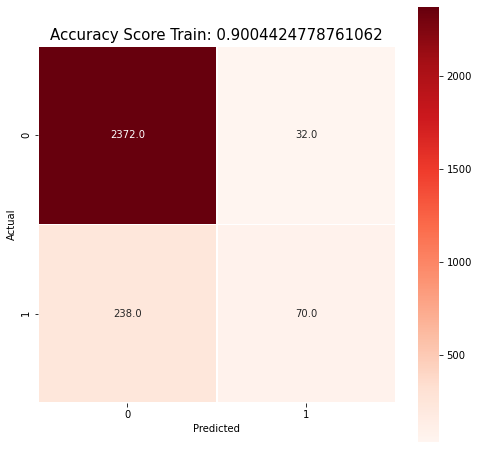

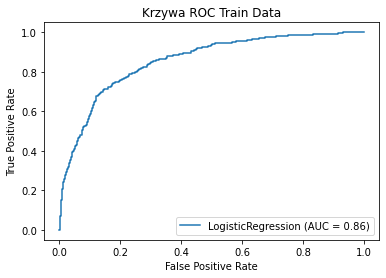

Accuracy Test Data: 0.89
Roc Auc Score Test Data: 0.56
Precision Test Data: 0.64
F1 Test Data: 0.21
Recall Test Data: 0.13


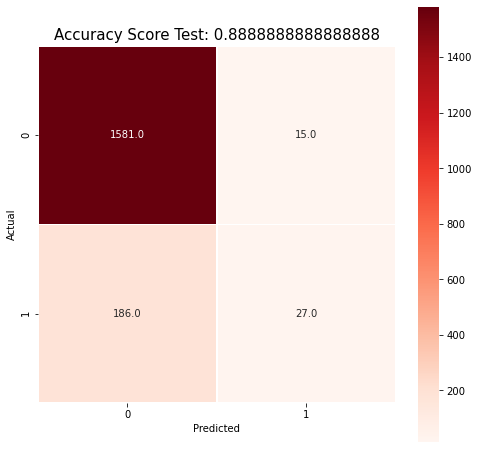

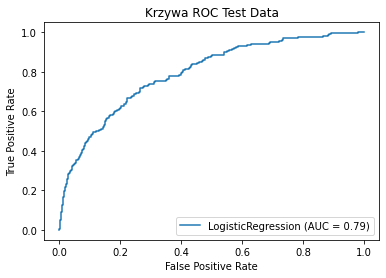

In [38]:
LR = LogisticRegression(solver = 'liblinear', random_state=0)
LR.fit(X_train, y_train)
y_pred_test = LR.predict(X_test)
y_pred_train = LR.predict(X_train)

names = ['Miary']
accuracy_train = ['Accuracy']
roc_train = ['Roc']
precision_train = ['Precision']
f1_train = ['F1']
recall_train = ['Recall']
accuracy_test = ['Accuracy']
roc_test = ['Roc']
precision_test = ['Precision']
f1_test = ['F1']
recall_test = ['Recall']

names.append('Regresja logistyczna')


print("Accuracy Train Data: "+str(round(accuracy_score(y_train, y_pred_train),2)))
accuracy_train.append(str(round(accuracy_score(y_train, y_pred_train),2)))
print("Roc Auc Score Train Data: "+str(round(roc_auc_score(y_train, y_pred_train),2)))
roc_train.append(str(round(roc_auc_score(y_train, y_pred_train),2)))
print("Precision Train Data: "+str(round(precision_score(y_train, y_pred_train),2)))
precision_train.append(str(round(precision_score(y_train, y_pred_train),2)))
print("F1 Train Data: "+str(round(f1_score(y_train, y_pred_train),2)))
f1_train.append(str(round(f1_score(y_train, y_pred_train),2)))
print("Recall Train Data: "+str(round(recall_score(y_train, y_pred_train),2)))
recall_train.append(str(round(recall_score(y_train, y_pred_train),2)))

confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Train: {0}'.format(accuracy_score(y_train, y_pred_train))
plt.title(title, size = 15);

metrics.plot_roc_curve(LR, X_train, y_train)
plt.title("Krzywa ROC Train Data")
plt.show() 


print("Accuracy Test Data: "+str(round(accuracy_score(y_test, y_pred_test),2)))
accuracy_test.append(str(round(accuracy_score(y_test, y_pred_test),2)))
print("Roc Auc Score Test Data: "+str(round(roc_auc_score(y_test, y_pred_test),2)))
roc_test.append(str(round(roc_auc_score(y_test, y_pred_test),2)))
print("Precision Test Data: "+str(round(precision_score(y_test, y_pred_test),2)))
precision_test.append(str(round(precision_score(y_test, y_pred_test),2)))
print("F1 Test Data: "+str(round(f1_score(y_test, y_pred_test),2)))
f1_test.append(str(round(f1_score(y_test, y_pred_test),2)))
print("Recall Test Data: "+str(round(recall_score(y_test, y_pred_test),2)))
recall_test.append(str(round(recall_score(y_test, y_pred_test),2)))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Test: {0}'.format(accuracy_score(y_test, y_pred_test))
plt.title(title, size = 15);

metrics.plot_roc_curve(LR, X_test, y_test)
plt.title("Krzywa ROC Test Data")
plt.show() 

# SVM

Accuracy Train Data: 0.89
Roc Auc Score Train Data: 0.58
Precision Train Data: 0.62
F1 Train Data: 0.27
Recall Train Data: 0.17


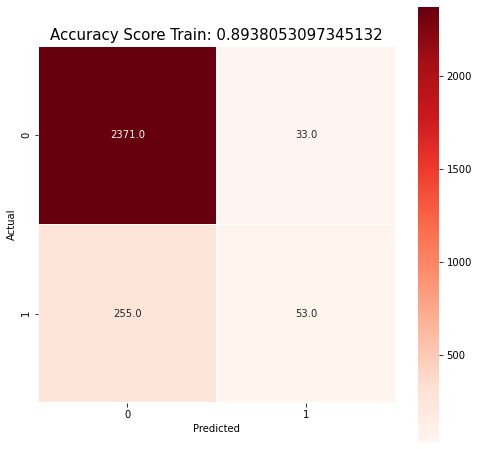

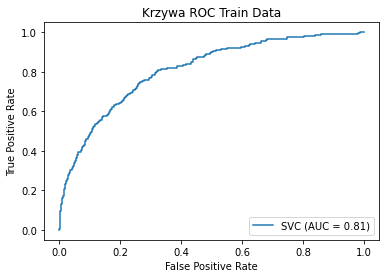

Accuracy Test Data: 0.89
Roc Auc Score Test Data: 0.57
Precision Test Data: 0.7
F1 Test Data: 0.23
Recall Test Data: 0.14


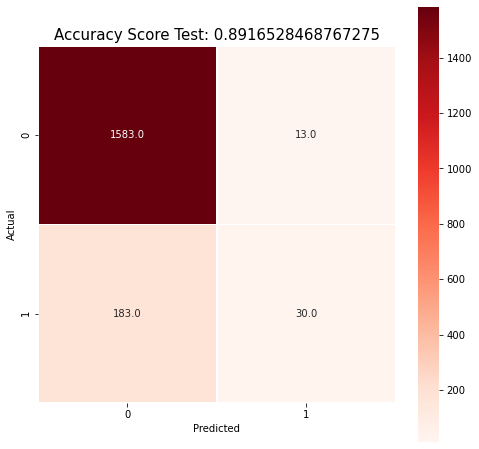

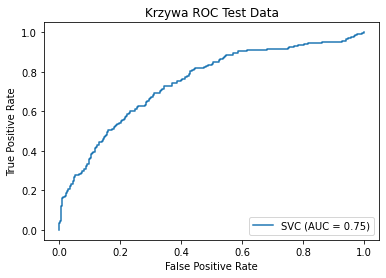

In [39]:
SVC = SVC(kernel = 'linear')
SVC.fit(X_train, y_train)
y_pred_test = SVC.predict(X_test)
y_pred_train = SVC.predict(X_train) 


names.append('SVM')


print("Accuracy Train Data: "+str(round(accuracy_score(y_train, y_pred_train),2)))
accuracy_train.append(str(round(accuracy_score(y_train, y_pred_train),2)))
print("Roc Auc Score Train Data: "+str(round(roc_auc_score(y_train, y_pred_train),2)))
roc_train.append(str(round(roc_auc_score(y_train, y_pred_train),2)))
print("Precision Train Data: "+str(round(precision_score(y_train, y_pred_train),2)))
precision_train.append(str(round(precision_score(y_train, y_pred_train),2)))
print("F1 Train Data: "+str(round(f1_score(y_train, y_pred_train),2)))
f1_train.append(str(round(f1_score(y_train, y_pred_train),2)))
print("Recall Train Data: "+str(round(recall_score(y_train, y_pred_train),2)))
recall_train.append(str(round(recall_score(y_train, y_pred_train),2)))

confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Train: {0}'.format(accuracy_score(y_train, y_pred_train))
plt.title(title, size = 15);

metrics.plot_roc_curve(SVC, X_train, y_train)
plt.title("Krzywa ROC Train Data")
plt.show() 


print("Accuracy Test Data: "+str(round(accuracy_score(y_test, y_pred_test),2)))
accuracy_test.append(str(round(accuracy_score(y_test, y_pred_test),2)))
print("Roc Auc Score Test Data: "+str(round(roc_auc_score(y_test, y_pred_test),2)))
roc_test.append(str(round(roc_auc_score(y_test, y_pred_test),2)))
print("Precision Test Data: "+str(round(precision_score(y_test, y_pred_test),2)))
precision_test.append(str(round(precision_score(y_test, y_pred_test),2)))
print("F1 Test Data: "+str(round(f1_score(y_test, y_pred_test),2)))
f1_test.append(str(round(f1_score(y_test, y_pred_test),2)))
print("Recall Test Data: "+str(round(recall_score(y_test, y_pred_test),2)))
recall_test.append(str(round(recall_score(y_test, y_pred_test),2)))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Test: {0}'.format(accuracy_score(y_test, y_pred_test))
plt.title(title, size = 15);

metrics.plot_roc_curve(SVC, X_test, y_test)
plt.title("Krzywa ROC Test Data")
plt.show() 

# Drzewo decyzyjne - kryterium entropy

Accuracy Train Data: 1.0
Roc Auc Score Train Data: 1.0
Precision Train Data: 1.0
F1 Train Data: 1.0
Recall Train Data: 1.0


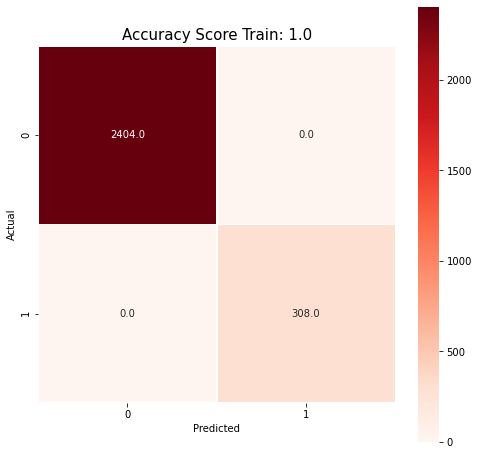

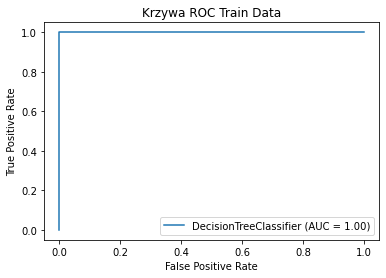

Accuracy Test Data: 0.82
Roc Auc Score Test Data: 0.61
Precision Test Data: 0.28
F1 Test Data: 0.31
Recall Test Data: 0.34


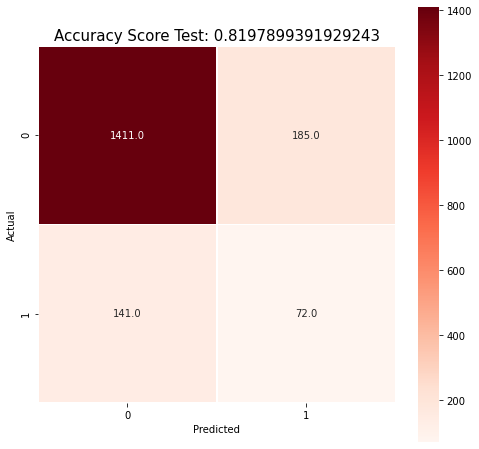

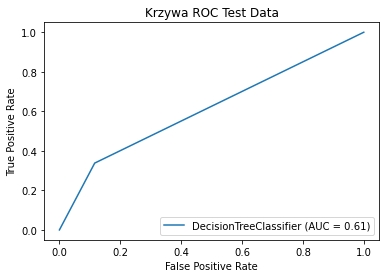

In [40]:
DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0 , splitter = 'best')
DT.fit(X_train, y_train)
y_pred_test = DT.predict(X_test)
y_pred_train = DT.predict(X_train) 

names.append('Drzewo decyzyjne')


print("Accuracy Train Data: "+str(round(accuracy_score(y_train, y_pred_train),2)))
accuracy_train.append(str(round(accuracy_score(y_train, y_pred_train),2)))
print("Roc Auc Score Train Data: "+str(round(roc_auc_score(y_train, y_pred_train),2)))
roc_train.append(str(round(roc_auc_score(y_train, y_pred_train),2)))
print("Precision Train Data: "+str(round(precision_score(y_train, y_pred_train),2)))
precision_train.append(str(round(precision_score(y_train, y_pred_train),2)))
print("F1 Train Data: "+str(round(f1_score(y_train, y_pred_train),2)))
f1_train.append(str(round(f1_score(y_train, y_pred_train),2)))
print("Recall Train Data: "+str(round(recall_score(y_train, y_pred_train),2)))
recall_train.append(str(round(recall_score(y_train, y_pred_train),2)))

confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Train: {0}'.format(accuracy_score(y_train, y_pred_train))
plt.title(title, size = 15);

metrics.plot_roc_curve(DT, X_train, y_train)
plt.title("Krzywa ROC Train Data")
plt.show() 


print("Accuracy Test Data: "+str(round(accuracy_score(y_test, y_pred_test),2)))
accuracy_test.append(str(round(accuracy_score(y_test, y_pred_test),2)))
print("Roc Auc Score Test Data: "+str(round(roc_auc_score(y_test, y_pred_test),2)))
roc_test.append(str(round(roc_auc_score(y_test, y_pred_test),2)))
print("Precision Test Data: "+str(round(precision_score(y_test, y_pred_test),2)))
precision_test.append(str(round(precision_score(y_test, y_pred_test),2)))
print("F1 Test Data: "+str(round(f1_score(y_test, y_pred_test),2)))
f1_test.append(str(round(f1_score(y_test, y_pred_test),2)))
print("Recall Test Data: "+str(round(recall_score(y_test, y_pred_test),2)))
recall_test.append(str(round(recall_score(y_test, y_pred_test),2)))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Test: {0}'.format(accuracy_score(y_test, y_pred_test))
plt.title(title, size = 15);

metrics.plot_roc_curve(DT, X_test, y_test)
plt.title("Krzywa ROC Test Data")
plt.show() 

# Algorytm K najbliższych sąsiadów

Accuracy Train Data: 0.91
Roc Auc Score Train Data: 0.62
Precision Train Data: 0.75
F1 Train Data: 0.37
Recall Train Data: 0.25


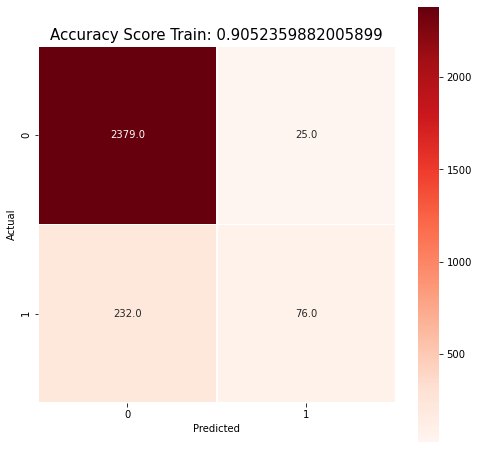

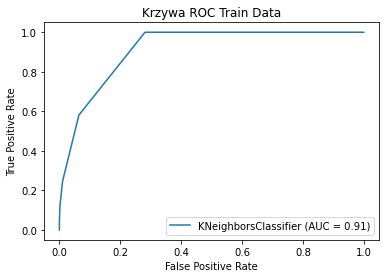

Accuracy Test Data: 0.88
Roc Auc Score Test Data: 0.54
Precision Test Data: 0.41
F1 Test Data: 0.16
Recall Test Data: 0.1


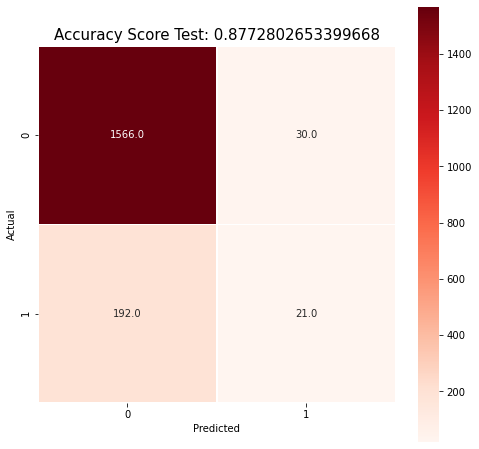

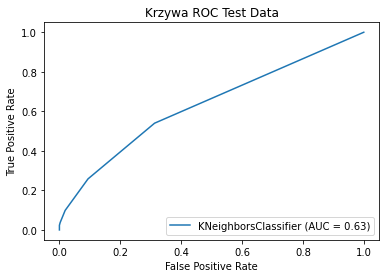

In [41]:
KN = KNeighborsClassifier(metric = "euclidean")
KN.fit(X_train, y_train)
y_pred_test = KN.predict(X_test)
y_pred_train = KN.predict(X_train) 

names.append('K najbliższych sąsiadów')


print("Accuracy Train Data: "+str(round(accuracy_score(y_train, y_pred_train),2)))
accuracy_train.append(str(round(accuracy_score(y_train, y_pred_train),2)))
print("Roc Auc Score Train Data: "+str(round(roc_auc_score(y_train, y_pred_train),2)))
roc_train.append(str(round(roc_auc_score(y_train, y_pred_train),2)))
print("Precision Train Data: "+str(round(precision_score(y_train, y_pred_train),2)))
precision_train.append(str(round(precision_score(y_train, y_pred_train),2)))
print("F1 Train Data: "+str(round(f1_score(y_train, y_pred_train),2)))
f1_train.append(str(round(f1_score(y_train, y_pred_train),2)))
print("Recall Train Data: "+str(round(recall_score(y_train, y_pred_train),2)))
recall_train.append(str(round(recall_score(y_train, y_pred_train),2)))

confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Train: {0}'.format(accuracy_score(y_train, y_pred_train))
plt.title(title, size = 15);

metrics.plot_roc_curve(KN, X_train, y_train)
plt.title("Krzywa ROC Train Data")
plt.show() 


print("Accuracy Test Data: "+str(round(accuracy_score(y_test, y_pred_test),2)))
accuracy_test.append(str(round(accuracy_score(y_test, y_pred_test),2)))
print("Roc Auc Score Test Data: "+str(round(roc_auc_score(y_test, y_pred_test),2)))
roc_test.append(str(round(roc_auc_score(y_test, y_pred_test),2)))
print("Precision Test Data: "+str(round(precision_score(y_test, y_pred_test),2)))
precision_test.append(str(round(precision_score(y_test, y_pred_test),2)))
print("F1 Test Data: "+str(round(f1_score(y_test, y_pred_test),2)))
f1_test.append(str(round(f1_score(y_test, y_pred_test),2)))
print("Recall Test Data: "+str(round(recall_score(y_test, y_pred_test),2)))
recall_test.append(str(round(recall_score(y_test, y_pred_test),2)))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Test: {0}'.format(accuracy_score(y_test, y_pred_test))
plt.title(title, size = 15);

metrics.plot_roc_curve(KN, X_test, y_test)
plt.title("Krzywa ROC Test Data")
plt.show() 

# Lasy losowe kryterium Gini

Accuracy Train Data: 1.0
Roc Auc Score Train Data: 1.0
Precision Train Data: 1.0
F1 Train Data: 1.0
Recall Train Data: 1.0


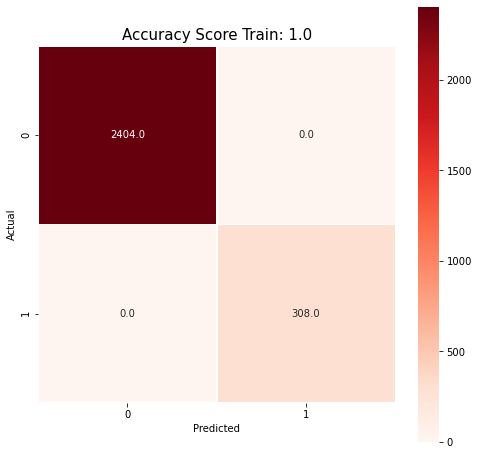

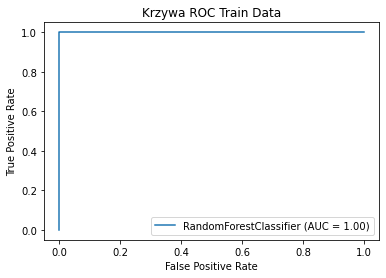

Accuracy Test Data: 0.88
Roc Auc Score Test Data: 0.52
Precision Test Data: 0.59
F1 Test Data: 0.09
Recall Test Data: 0.05


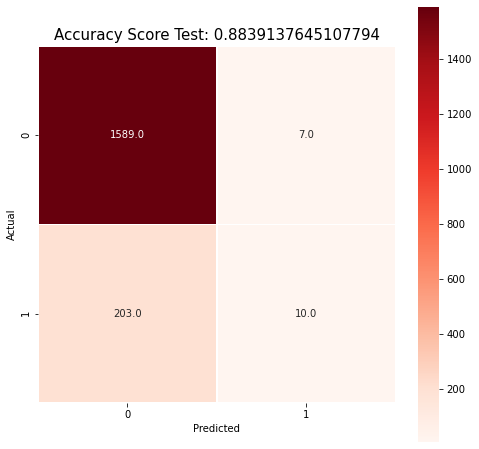

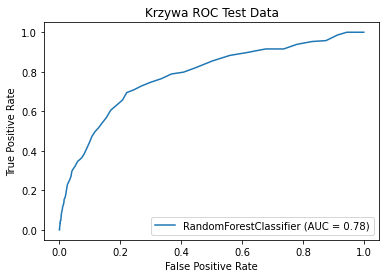

In [42]:
RF = RandomForestClassifier(criterion = 'gini')
RF.fit(X_train, y_train)
y_pred_test = RF.predict(X_test)
y_pred_train = RF.predict(X_train) 

names.append('Lasy losowe')


print("Accuracy Train Data: "+str(round(accuracy_score(y_train, y_pred_train),2)))
accuracy_train.append(str(round(accuracy_score(y_train, y_pred_train),2)))
print("Roc Auc Score Train Data: "+str(round(roc_auc_score(y_train, y_pred_train),2)))
roc_train.append(str(round(roc_auc_score(y_train, y_pred_train),2)))
print("Precision Train Data: "+str(round(precision_score(y_train, y_pred_train),2)))
precision_train.append(str(round(precision_score(y_train, y_pred_train),2)))
print("F1 Train Data: "+str(round(f1_score(y_train, y_pred_train),2)))
f1_train.append(str(round(f1_score(y_train, y_pred_train),2)))
print("Recall Train Data: "+str(round(recall_score(y_train, y_pred_train),2)))
recall_train.append(str(round(recall_score(y_train, y_pred_train),2)))

confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Train: {0}'.format(accuracy_score(y_train, y_pred_train))
plt.title(title, size = 15);

metrics.plot_roc_curve(RF, X_train, y_train)
plt.title("Krzywa ROC Train Data")
plt.show() 


print("Accuracy Test Data: "+str(round(accuracy_score(y_test, y_pred_test),2)))
accuracy_test.append(str(round(accuracy_score(y_test, y_pred_test),2)))
print("Roc Auc Score Test Data: "+str(round(roc_auc_score(y_test, y_pred_test),2)))
roc_test.append(str(round(roc_auc_score(y_test, y_pred_test),2)))
print("Precision Test Data: "+str(round(precision_score(y_test, y_pred_test),2)))
precision_test.append(str(round(precision_score(y_test, y_pred_test),2)))
print("F1 Test Data: "+str(round(f1_score(y_test, y_pred_test),2)))
f1_test.append(str(round(f1_score(y_test, y_pred_test),2)))
print("Recall Test Data: "+str(round(recall_score(y_test, y_pred_test),2)))
recall_test.append(str(round(recall_score(y_test, y_pred_test),2)))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Test: {0}'.format(accuracy_score(y_test, y_pred_test))
plt.title(title, size = 15);

metrics.plot_roc_curve(RF, X_test, y_test)
plt.title("Krzywa ROC Test Data")
plt.show() 



# Naiwny klasyfikator bayesowski

Accuracy Train Data: 0.75
Roc Auc Score Train Data: 0.69
Precision Train Data: 0.25
F1 Train Data: 0.35
Recall Train Data: 0.6


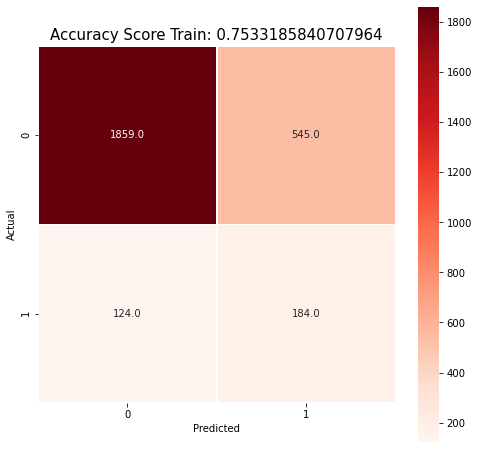

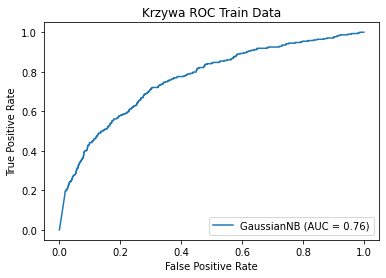

Accuracy Test Data: 0.82
Roc Auc Score Test Data: 0.58
Precision Test Data: 0.26
F1 Test Data: 0.26
Recall Test Data: 0.26


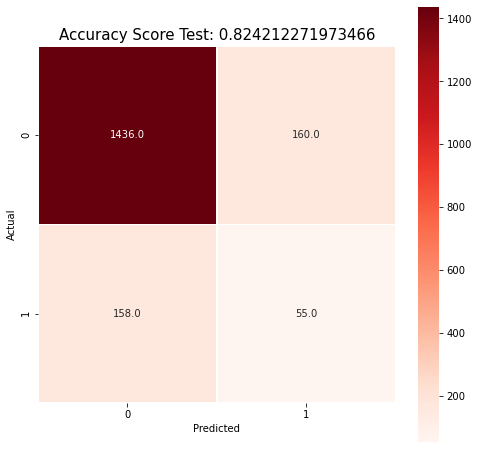

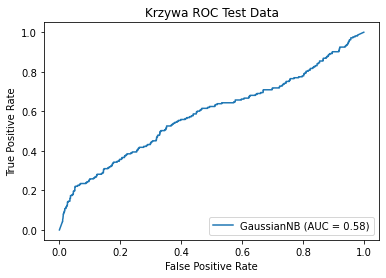

In [43]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)
y_pred_test = GNB.predict(X_test)
y_pred_train = GNB.predict(X_train) 

names.append('Naiwny klasyfikator bayesowski')


print("Accuracy Train Data: "+str(round(accuracy_score(y_train, y_pred_train),2)))
accuracy_train.append(str(round(accuracy_score(y_train, y_pred_train),2)))
print("Roc Auc Score Train Data: "+str(round(roc_auc_score(y_train, y_pred_train),2)))
roc_train.append(str(round(roc_auc_score(y_train, y_pred_train),2)))
print("Precision Train Data: "+str(round(precision_score(y_train, y_pred_train),2)))
precision_train.append(str(round(precision_score(y_train, y_pred_train),2)))
print("F1 Train Data: "+str(round(f1_score(y_train, y_pred_train),2)))
f1_train.append(str(round(f1_score(y_train, y_pred_train),2)))
print("Recall Train Data: "+str(round(recall_score(y_train, y_pred_train),2)))
recall_train.append(str(round(recall_score(y_train, y_pred_train),2)))

confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Train: {0}'.format(accuracy_score(y_train, y_pred_train))
plt.title(title, size = 15);

metrics.plot_roc_curve(GNB, X_train, y_train)
plt.title("Krzywa ROC Train Data")
plt.show() 


print("Accuracy Test Data: "+str(round(accuracy_score(y_test, y_pred_test),2)))
accuracy_test.append(str(round(accuracy_score(y_test, y_pred_test),2)))
print("Roc Auc Score Test Data: "+str(round(roc_auc_score(y_test, y_pred_test),2)))
roc_test.append(str(round(roc_auc_score(y_test, y_pred_test),2)))
print("Precision Test Data: "+str(round(precision_score(y_test, y_pred_test),2)))
precision_test.append(str(round(precision_score(y_test, y_pred_test),2)))
print("F1 Test Data: "+str(round(f1_score(y_test, y_pred_test),2)))
f1_test.append(str(round(f1_score(y_test, y_pred_test),2)))
print("Recall Test Data: "+str(round(recall_score(y_test, y_pred_test),2)))
recall_test.append(str(round(recall_score(y_test, y_pred_test),2)))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Test: {0}'.format(accuracy_score(y_test, y_pred_test))
plt.title(title, size = 15);

metrics.plot_roc_curve(GNB, X_test, y_test)
plt.title("Krzywa ROC Test Data")
plt.show() 


# Sieć neuronowa

In [44]:
ANN = Sequential()
ANN.add(Dense(units = 64, kernel_regularizer=tf.keras.regularizers.l2(0.001) , activation = 'relu'))
ANN.add(Dense(units = 1, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation = 'sigmoid'))
ANN.compile(loss = 'binary_crossentropy', optimizer = 'adam',  metrics = ['accuracy'])
ANN.fit(X_train, y_train, batch_size = 10, epochs = 30)

Epoch 1/30
272/272 [==============================] - 15s 902us/step - loss: 0.4657 - accuracy: 0.8544
Epoch 2/30
272/272 [==============================] - 0s 978us/step - loss: 0.3391 - accuracy: 0.8896
Epoch 3/30
272/272 [==============================] - 0s 886us/step - loss: 0.3264 - accuracy: 0.8919
Epoch 4/30
272/272 [==============================] - 0s 712us/step - loss: 0.3169 - accuracy: 0.8914
Epoch 5/30
272/272 [==============================] - 0s 845us/step - loss: 0.3017 - accuracy: 0.8936
Epoch 6/30
272/272 [==============================] - 0s 818us/step - loss: 0.3054 - accuracy: 0.8946
Epoch 7/30
272/272 [==============================] - 0s 755us/step - loss: 0.3314 - accuracy: 0.8849
Epoch 8/30
272/272 [==============================] - 0s 611us/step - loss: 0.2965 - accuracy: 0.8970
Epoch 9/30
272/272 [==============================] - 0s 757us/step - loss: 0.2741 - accuracy: 0.9057
Epoch 10/30
272/272 [==============================] - 0s 847us/step - loss: 0.27

Accuracy Train Data: 0.91
Roc Auc Score Train Data: 0.64
Precision Train Data: 0.69
F1 Train Data: 0.42
Recall Train Data: 0.3


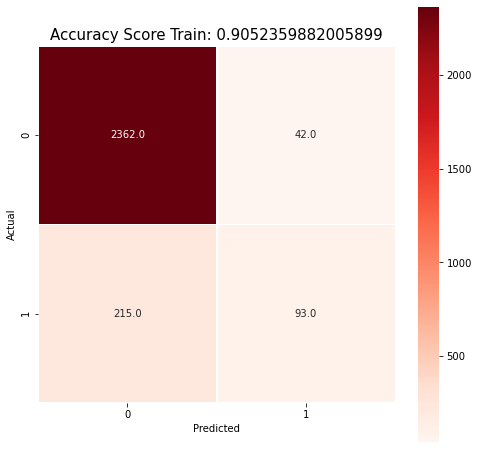

Accuracy Test Data: 0.89
Roc Auc Score Test Data: 0.58
Precision Test Data: 0.64
F1 Test Data: 0.26
Recall Test Data: 0.16


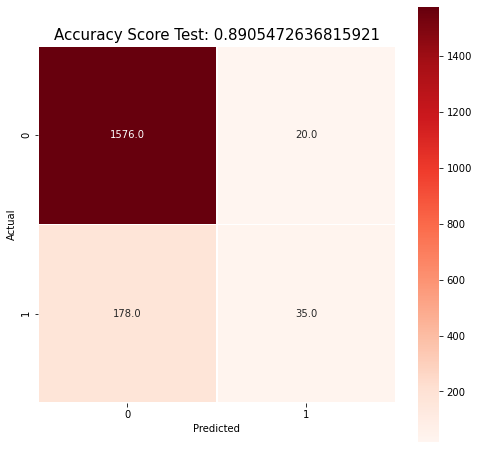

In [45]:
y_pred_test = ANN.predict(X_test)
y_pred_test = (y_pred_test > 0.5)

y_pred_train = ANN.predict(X_train)
y_pred_train = (y_pred_train > 0.5)

names.append('Sieć neuronowa')


print("Accuracy Train Data: "+str(round(accuracy_score(y_train, y_pred_train),2)))
accuracy_train.append(str(round(accuracy_score(y_train, y_pred_train),2)))
print("Roc Auc Score Train Data: "+str(round(roc_auc_score(y_train, y_pred_train),2)))
roc_train.append(str(round(roc_auc_score(y_train, y_pred_train),2)))
print("Precision Train Data: "+str(round(precision_score(y_train, y_pred_train),2)))
precision_train.append(str(round(precision_score(y_train, y_pred_train),2)))
print("F1 Train Data: "+str(round(f1_score(y_train, y_pred_train),2)))
f1_train.append(str(round(f1_score(y_train, y_pred_train),2)))
print("Recall Train Data: "+str(round(recall_score(y_train, y_pred_train),2)))
recall_train.append(str(round(recall_score(y_train, y_pred_train),2)))

confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Train: {0}'.format(accuracy_score(y_train, y_pred_train))
plt.title(title, size = 15);

# metrics.plot_roc_curve(ANN, X_train, y_train)
# plt.title("Krzywa ROC Train Data")
plt.show() 


print("Accuracy Test Data: "+str(round(accuracy_score(y_test, y_pred_test),2)))
accuracy_test.append(str(round(accuracy_score(y_test, y_pred_test),2)))
print("Roc Auc Score Test Data: "+str(round(roc_auc_score(y_test, y_pred_test),2)))
roc_test.append(str(round(roc_auc_score(y_test, y_pred_test),2)))
print("Precision Test Data: "+str(round(precision_score(y_test, y_pred_test),2)))
precision_test.append(str(round(precision_score(y_test, y_pred_test),2)))
print("F1 Test Data: "+str(round(f1_score(y_test, y_pred_test),2)))
f1_test.append(str(round(f1_score(y_test, y_pred_test),2)))
print("Recall Test Data: "+str(round(recall_score(y_test, y_pred_test),2)))
recall_test.append(str(round(recall_score(y_test, y_pred_test),2)))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap='Reds');
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy Score Test: {0}'.format(accuracy_score(y_test, y_pred_test))
plt.title(title, size = 15);

# metrics.plot_roc_curve(ANN, X_test, y_test)
# plt.title("Krzywa ROC Test Data")
# plt.show() 

# Tabele porówania modeli

Zbiór treningowy

In [46]:
model_comparison_train = pd.DataFrame([accuracy_train,
roc_train,
precision_train,
f1_train,
recall_train], columns = names)
model_comparison_train = model_comparison_train.set_index('Miary')

In [47]:
model_comparison_train

,Regresja logistyczna,SVM,Drzewo decyzyjne,K najbliższych sąsiadów,Lasy losowe,Naiwny klasyfikator bayesowski,Sieć neuronowa
Miary,,,,,,,
Accuracy,0.9,0.89,1.0,0.91,1.0,0.75,0.91
Roc,0.61,0.58,1.0,0.62,1.0,0.69,0.64
Precision,0.69,0.62,1.0,0.75,1.0,0.25,0.69
F1,0.34,0.27,1.0,0.37,1.0,0.35,0.42
Recall,0.23,0.17,1.0,0.25,1.0,0.6,0.3


Zbiór testowy

In [48]:
model_comparison_test = pd.DataFrame([accuracy_test,
roc_test,
precision_test,
f1_test,
recall_test], columns = names)
model_comparison_test = model_comparison_test.set_index('Miary')

In [49]:
model_comparison_test

,Regresja logistyczna,SVM,Drzewo decyzyjne,K najbliższych sąsiadów,Lasy losowe,Naiwny klasyfikator bayesowski,Sieć neuronowa
Miary,,,,,,,
Accuracy,0.89,0.89,0.82,0.88,0.88,0.82,0.89
Roc,0.56,0.57,0.61,0.54,0.52,0.58,0.58
Precision,0.64,0.7,0.28,0.41,0.59,0.26,0.64
F1,0.21,0.23,0.31,0.16,0.09,0.26,0.26
Recall,0.13,0.14,0.34,0.1,0.05,0.26,0.16
